In [ ]:
import sys
sys.path.append("../src")

import numpy as np
import matplotlib.pyplot as plt

from pdg_env import PDGGridParallelEnv, PDGPayoffs
from agents import make_agents
from loop_pz import run_simulation

from analysis_PDG import (
    coop_timecourse_mean_sd,
    mean_coop,
    cc_mcc,
    alpha_fit_polyfit
)

SEED = 123
rng = np.random.default_rng(SEED)

PAYOFFS = PDGPayoffs(R=3.0, T=5.0, S=0.0, P=1.0)

# fix parameters
EPSILON = 0.2
P_INIT = 0.5
GRID_SIZE = 10


In [ ]:
def make_env(tmax):
    return PDGGridParallelEnv(
        size=GRID_SIZE,
        ep_leng=tmax,
        payoffs=PAYOFFS
    )

def make_agents_list(n_agents, A, beta, epsilon=EPSILON, p_init=P_INIT):
    return make_agents(n_agents, A=A, beta=beta, epsilon=epsilon, p_init=p_init)

def run_trials(A, beta, tmax, n_trials, seed=SEED, epsilon=EPSILON, p_init=P_INIT):
    env = make_env(tmax=tmax)
    agents = make_agents_list(env.n_agents, A=A, beta=beta, epsilon=epsilon, p_init=p_init)
    actions_all, rewards_all, p_all, _ = run_simulation(
        env=env,
        agents=agents,
        n_episodes=n_trials,
        ep_lenght_max=tmax,
        seed=seed,
        render=False
    )
    return env, actions_all, rewards_all, p_all


# Fig2A

In [ ]:
tmax_2A = 100
beta_2A = 0.2
A_list_2A = [0.5, 1.5]

n_trials_2A = 500 # increase to 1000 for final figure

res_2A = {}
for A in A_list_2A:
    env, actions_all, rewards_all, p_all = run_trials(
        A=A, beta=beta_2A, tmax=tmax_2A, n_trials=n_trials_2A, seed=SEED + int(A*1000)
    )
    res_2A[A] = actions_all

print("Done Fig 2A sims.")


Done Fig 2A sims.


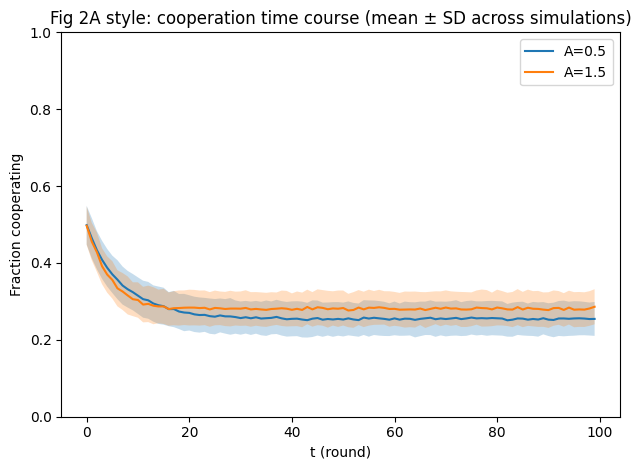

In [22]:
plt.figure()

for A in A_list_2A:
    actions_all = res_2A[A]
    mean_t, sd_t = coop_timecourse_mean_sd(actions_all)
    plt.plot(mean_t, label=f"A={A}")
    plt.fill_between(np.arange(tmax_2A), mean_t - sd_t, mean_t + sd_t, alpha=0.25)

plt.xlabel("t (round)")
plt.ylabel("Fraction cooperating")
plt.title("Fig 2A style: cooperation time course (mean ± SD across simulations)")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


# Fig 2B

In [ ]:
tmax_2B = 25
n_trials_2B = 10  # increase to 100 for final figure

A_values = np.linspace(-1.5, 3.0, 20)
beta_values = np.linspace(0.05, 2.0, 20)

coop_map_2B = np.zeros((len(A_values), len(beta_values)), dtype=float)

for iA, A in enumerate(A_values):
    for iB, beta in enumerate(beta_values):
        env, actions_all, _, _ = run_trials(
            A=A, beta=beta, tmax=tmax_2B, n_trials=n_trials_2B
        )
        coop_map_2B[iA, iB] = mean_coop(actions_all, t_start=0, t_end=tmax_2B)

print("Done Fig 2B sweep. coop_map shape:", coop_map_2B.shape)


Done Fig 2B sweep. coop_map shape: (20, 20)


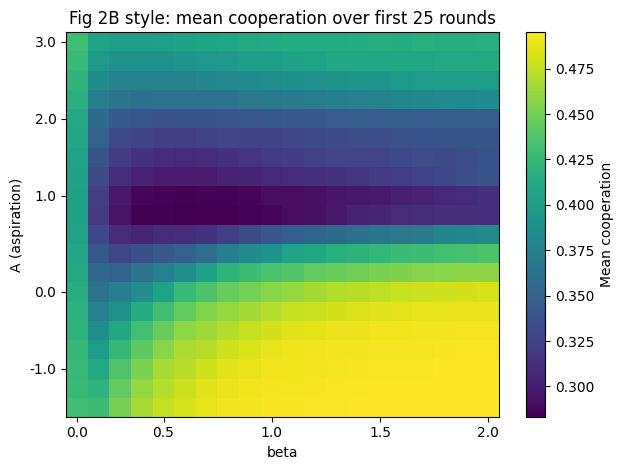

In [ ]:
plt.figure()
plt.imshow(coop_map_2B, origin="lower", aspect="auto")
plt.colorbar(label="Mean cooperation")

beta_ticks = [0.0, 0.5, 1.0, 1.5, 2.0]
A_ticks = [-1.0, 0.0, 1.0, 2.0, 3.0]

beta_idx = [int(np.argmin(np.abs(beta_values - v))) for v in beta_ticks]
A_idx = [int(np.argmin(np.abs(A_values - v))) for v in A_ticks]

plt.xticks(beta_idx, [str(v) for v in beta_ticks])
plt.yticks(A_idx, [str(v) for v in A_ticks])

plt.xlabel("beta")
plt.ylabel("A (aspiration)")
plt.title("Fig 2B style: mean cooperation over first 25 rounds")
plt.tight_layout()
plt.show()


# Fig 3

In [ ]:
tmax_3 = 25
n_trials_3 = 50  # increase to 100 for final figure

fig3_settings = [
    ("A", 0.5, 0.1),
    ("B", 0.5, 0.4),
    ("C", 2.0, 0.4),
    ("D", -1.0, 0.4),
]

fig3_curves = {}

for label, A, beta in fig3_settings:
    env, actions_all, _, _ = run_trials(
        A=A, beta=beta, tmax=tmax_3, n_trials=n_trials_3
    )
    curves = cc_mcc(actions_all, env.neighbors, t_start=1, t_end=tmax_3)
    fig3_curves[label] = (curves, A, beta)

print("Done Fig 3 sims.")


Done Fig 3 sims.


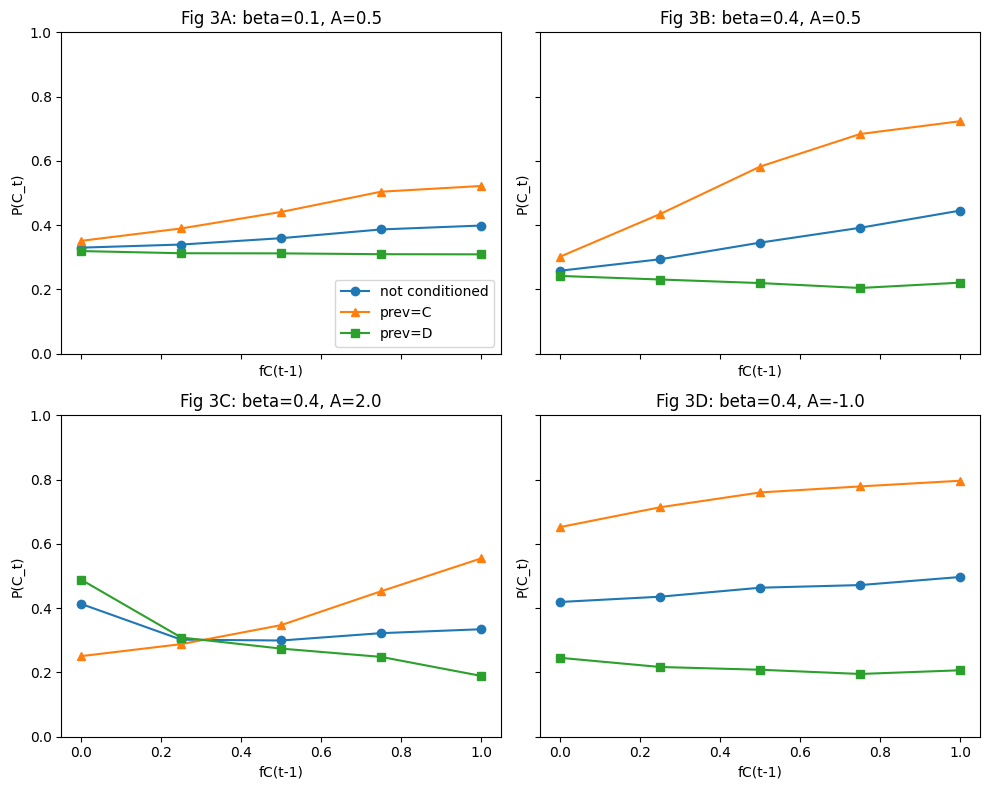

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()

for ax, (label, A, beta) in zip(axes, fig3_settings):
    curves, A, beta = fig3_curves[label]
    f = curves["f_vals"]

    ax.plot(f, curves["pC"], marker="o", label="not conditioned")
    ax.plot(f, curves["pC_C"], marker="^", label="prev=C")
    ax.plot(f, curves["pC_D"], marker="s", label="prev=D")

    ax.set_title(f"Fig 3{label}: beta={beta}, A={A}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("fC(t-1)")
    ax.set_ylabel("P(C_t)")

axes[0].legend(loc="lower right")
plt.tight_layout()
plt.show()


# Fig 4


In [ ]:
tmax_4 = 25
n_trials_4 = 10

A_values_4 = np.linspace(-1.5, 3.0, 20)
beta_values_4 = np.linspace(0.05, 2.0, 20)

a1_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)
a2_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)

a1C_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)
a2C_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)

a1D_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)
a2D_map = np.zeros((len(A_values_4), len(beta_values_4)), dtype=float)

for iA, A in enumerate(A_values_4):
    for iB, beta in enumerate(beta_values_4):
        env, actions_all, _, _ = run_trials(A=A, beta=beta, tmax=tmax_4, n_trials=n_trials_4)

        a1, a2, _ = alpha_fit_polyfit(actions_all, env.neighbors, condition=None,    t_start=1, t_end=tmax_4)
        a1C, a2C, _ = alpha_fit_polyfit(actions_all, env.neighbors, condition="prevC", t_start=1, t_end=tmax_4)
        a1D, a2D, _ = alpha_fit_polyfit(actions_all, env.neighbors, condition="prevD", t_start=1, t_end=tmax_4)

        a1_map[iA, iB], a2_map[iA, iB] = a1, a2
        a1C_map[iA, iB], a2C_map[iA, iB] = a1C, a2C
        a1D_map[iA, iB], a2D_map[iA, iB] = a1D, a2D

delta_a2 = a2C_map - a2D_map

print("Done Fig 4 sweep (polyfit).")


Done Fig 4 sweep (polyfit).


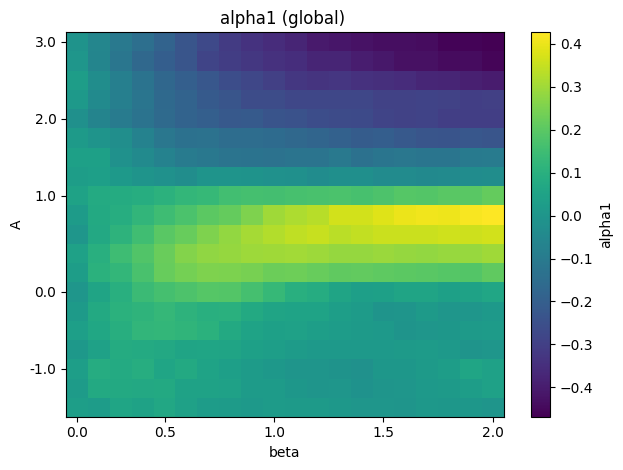

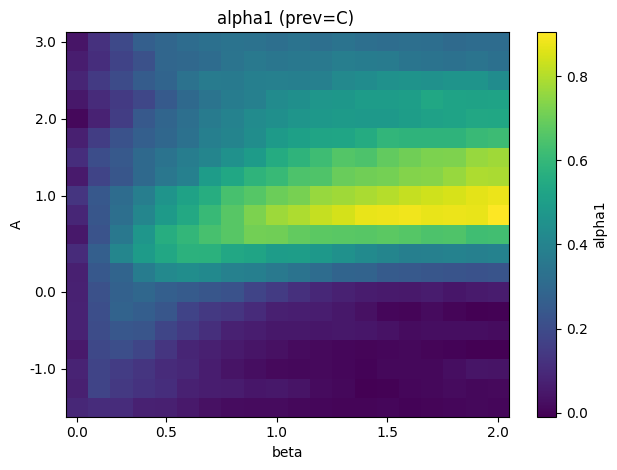

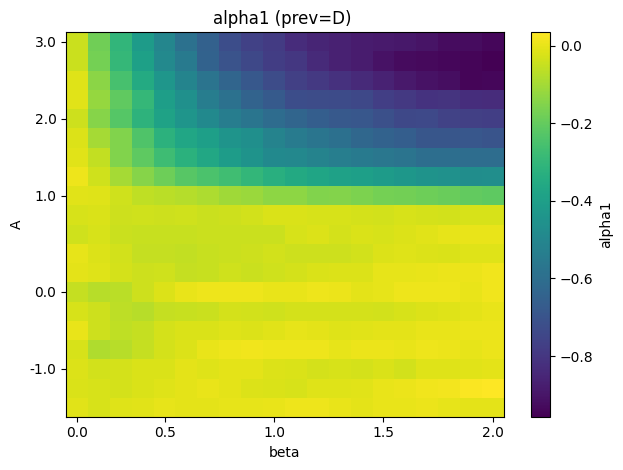

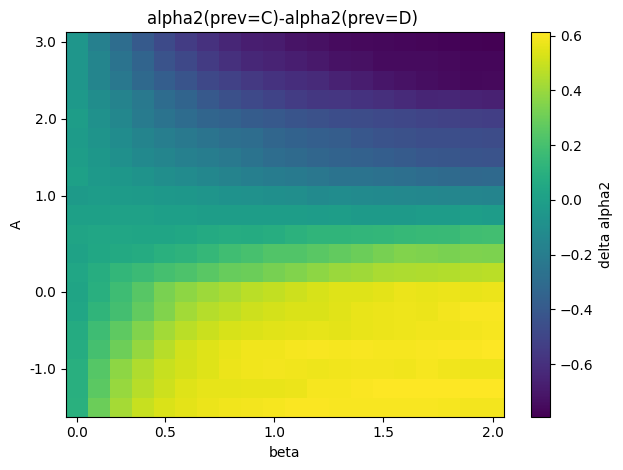

In [11]:
def show_heatmap(M, title, beta_values, A_values, cbar_label):
    plt.figure()
    im = plt.imshow(M, origin="lower", aspect="auto")
    cbar = plt.colorbar(im, label=cbar_label)

    beta_ticks = [0.0, 0.5, 1.0, 1.5, 2.0]
    A_ticks = [-1.0, 0.0, 1.0, 2.0, 3.0]
    beta_idx = [int(np.argmin(np.abs(beta_values - v))) for v in beta_ticks]
    A_idx = [int(np.argmin(np.abs(A_values - v))) for v in A_ticks]
    plt.xticks(beta_idx, [str(v) for v in beta_ticks])
    plt.yticks(A_idx, [str(v) for v in A_ticks])

    plt.xlabel("beta")
    plt.ylabel("A")
    plt.title(title)
    plt.tight_layout()
    plt.show()

show_heatmap(a1_map, "alpha1 (global) ", beta_values_4, A_values_4, "alpha1")
show_heatmap(a1C_map, "alpha1 (prev=C) ", beta_values_4, A_values_4, "alpha1")
show_heatmap(a1D_map, "alpha1 (prev=D) ", beta_values_4, A_values_4, "alpha1")
show_heatmap(delta_a2, "alpha2(prev=C)-alpha2(prev=D) ", beta_values_4, A_values_4, "delta alpha2")